# Peter Duggins
# SYDE 552/750
# Assignment: Neuron Responses
# March 15, 2016

In [32]:
%pylab inline
import numpy as np
from scipy import ndimage
import scipy.signal
import scipy.integrate
import pickle
import matplotlib.pyplot as plt
plt.rcParams['lines.linewidth'] = 4
plt.rcParams['font.size'] = 20

Populating the interactive namespace from numpy and matplotlib


## 1. Tuning Curves

Load the synthetic data file MT-direction-tuning. The file contains two variables: “direction” is a list of stimulus	directions for 200 trials. “spikeTimes” contains spike times for each trial.	

In [33]:
def load_data_one():

	tuning_data=pickle.load(open('MT-direction-tuning.pkl','rb'))
	directions=tuning_data['direction']
	spikeTimes=tuning_data['spikeTimes']
	return directions,spikeTimes

Plot the spike raster and the multi-trial firing rate (5ms bins) for 0-degree trials. Trial length is 2s.

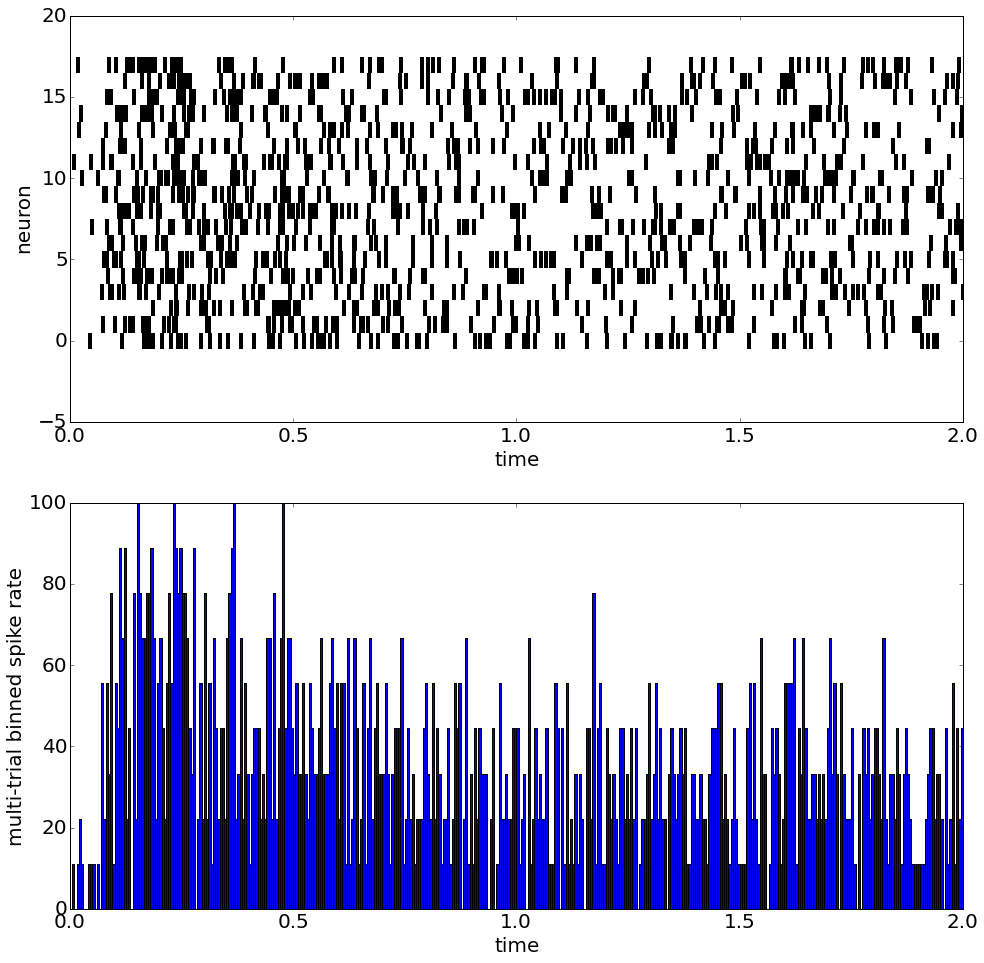

In [34]:
def one_b():

	#Load the synthetic data file MT-tuning-direction
	directions,spikeTimes=load_data_one()

	#Get the indices of the trials with 0 degree stimulus direction
	zero_degree_indices=np.where(directions==0)

	#Get the spike timing data from those trials
	ugly_arrays=spikeTimes[zero_degree_indices]
	zero_degree_spike_trials=np.array([ugly_arrays[i].flatten()
		for i in range(len(ugly_arrays))])

	#Calculate the 'multi-trial' (or 'time-varying') firing rate
	#by counting the number of spikes in a small time window,
    #dividing by the bin size, and averaging accross all trials
	T=2.0 #seconds
	bin_width=0.005
	multitrial_binned_rate=[]
	for i in range(int(T/bin_width)):
		bin_i=[]
		for trial in zero_degree_spike_trials:        
			count=0
			for t in trial:
				if (i*bin_width<=t<(i+1)*bin_width):
					count+=1.0
			bin_i.append(count/bin_width)
		multitrial_binned_rate.append(np.average(bin_i))

	#plot spike raster and multitrial firing rate
	fig=plt.figure(figsize=(16,16))
	ax=fig.add_subplot(211)
	ax.eventplot(zero_degree_spike_trials,colors=[[0,0,0]])
	ax.set_xlim(0,T)
	ax.set_xlabel('time')
	ax.set_ylabel('neuron')
	ax=fig.add_subplot(212)
	ax.bar(np.arange(0,T,bin_width),multitrial_binned_rate,width=bin_width)
	ax.set_xlim(0,T)
# 	ax.set_ylim(0,120)
	ax.set_xlabel('time')
	ax.set_ylabel('multi-trial binned spike rate')
	plt.show()
    
one_b()

Plot together the single-trial rates estimate for trial 9 using a Gaussian kernel with $SD=5$ms and $SD=50$ms. Use an appropriate sampling period so that rate fluctuations are not visibly distorted in the plot.

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:16: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


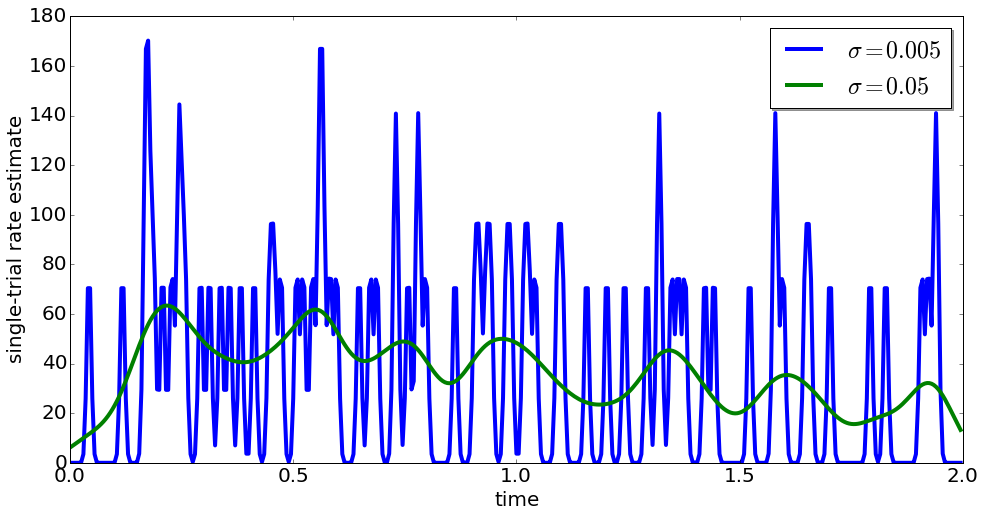

In [35]:
def one_c():

	#Load the synthetic data file MT-tuning-direction
	directions,spikeTimes=load_data_one()
	T=2.0 #seconds
	dt=0.005
	t=np.arange(0,T,dt)
	Nt=len(t)

	#Get the data from trial 9
	trial9_spikes=spikeTimes[0][8].flatten()

	#Create an array that has 1s at the spike times and zeros elsewhere
	trial9_raster=np.zeros((Nt))
	for spike in trial9_spikes:
		trial9_raster[spike/dt] = 1

	#Define the smoothing Gaussian kernels
	sigma1=0.005
	sigma2=0.05
	G1 = np.exp(-(t-np.average(t))**2/(2*sigma1**2))     
	G1 = G1 / sum(G1)  #normalize
	G2 = np.exp(-(t-np.average(t))**2/(2*sigma2**2))     
	G2 = G2 / sum(G2)  #normalize
    
	#You can also get the firing rate, then use the gaussian filter
	#package in scipy to get the same result.
	#Calculate the 'multi-trial' (or 'time-varying') firing rate
	#by counting the number of spikes in a small time window,
	#dividing by the bin size, and averaging accross all trials
	#T=2.0 #seconds
	#bin_width=0.005
	#t2=np.arange(0,T,bin_width)
	#binned_rate=[]
	#for i in range(int(T/bin_width)):
		#count=0.0        
		#for j in trial9_spikes:
			#if (i*bin_width<=j<(i+1)*bin_width):
				#count+=1.0
		#binned_rate.append(count/bin_width)

	#Convolve Gaussians with the spikes to calculate single-trial rate estimate
	trial9_smoothed1=np.convolve(trial9_raster,G1,'same')/dt
	trial9_smoothed2=np.convolve(trial9_raster,G2,'same')/dt
 	#trial9_smoothed3=scipy.ndimage.filters.gaussian_filter(binned_rate,sigma1/bin_width)
 	#trial9_smoothed4=scipy.ndimage.filters.gaussian_filter(binned_rate,sigma2/bin_width)
    
	#Plot the single-trial rate estimates
	fig=plt.figure(figsize=(16,8))
	ax=fig.add_subplot(111)
	ax.plot(t,trial9_smoothed1,label='$\\sigma=%s$' %sigma1)
	ax.plot(t,trial9_smoothed2,label='$\\sigma=%s$' %sigma2)
	#ax.plot(t2,trial9_smoothed3,label='$\\sigma=%s$' %sigma1)
	#ax.plot(t2,trial9_smoothed4,label='$\\sigma=%s$' %sigma2)
	# ax.set_xlim(0,T)
	ax.set_xlabel('time')
	ax.set_ylabel('single-trial rate estimate')
	legend=ax.legend(loc='best',shadow=True)
	plt.show()
    
one_c()

Plot the tuning curve with standard deviation error bars using data from 50-250ms

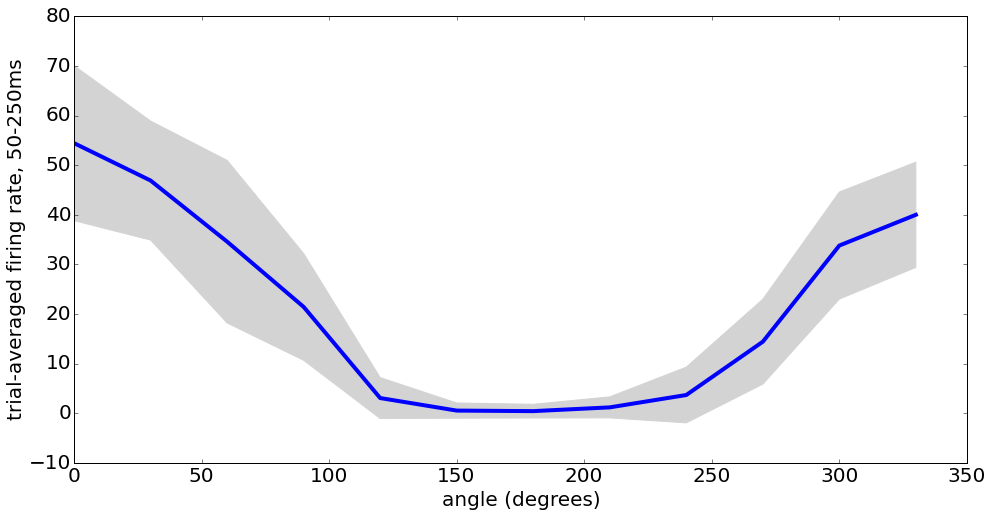

In [36]:
def one_d():

	#Load the synthetic data file MT-tuning-direction
	directions,spikeTimes=load_data_one()
	T=2.0 #seconds

	#find the unique direction values in the directions array
	unique_directions=np.unique(directions)

	#for each unique direction, find the trial indices in that direction
	trial_indices=np.array([np.where(directions==u)[1].tolist()
		for u in unique_directions])

	#calculate spike rate = spike count/time for each direction, avg over trials
	rate_vs_direction_mean=[]
	rate_vs_direction_std=[]
	for direction in trial_indices:
		dir_spikes_count=[]
		for trial in direction:
			trial_spike_times=spikeTimes[0][trial][0]
			#find indices of spikes between 50 and 250 ms
			fifty_to_twofifty_indices=np.where(trial_spike_times[
				(0.050<=trial_spike_times) & (trial_spike_times<=0.250)])[0]
			fifty_to_twofifty_spike_count=len(fifty_to_twofifty_indices)
			dir_spikes_count.append(fifty_to_twofifty_spike_count)
		rate_vs_direction_mean.append(np.average(dir_spikes_count)/(0.250-0.050))
		rate_vs_direction_std.append(np.std(dir_spikes_count)/(0.250-0.050))

	#Plot the tuning curve
	fig=plt.figure(figsize=(16,8))
	ax=fig.add_subplot(111)
	ax.plot(unique_directions,rate_vs_direction_mean)
	ax.fill_between(unique_directions,
		np.subtract(rate_vs_direction_mean,rate_vs_direction_std),
		np.add(rate_vs_direction_mean,rate_vs_direction_std),
		color='lightgray')
	ax.set_xlabel('angle (degrees)')
	ax.set_ylabel('trial-averaged firing rate, 50-250ms')
	plt.show()
    
one_d()

Search the electrophysiology literature to find a (real) tuning curve from a mouse. Include and explain a figure that shows the tuning curve.

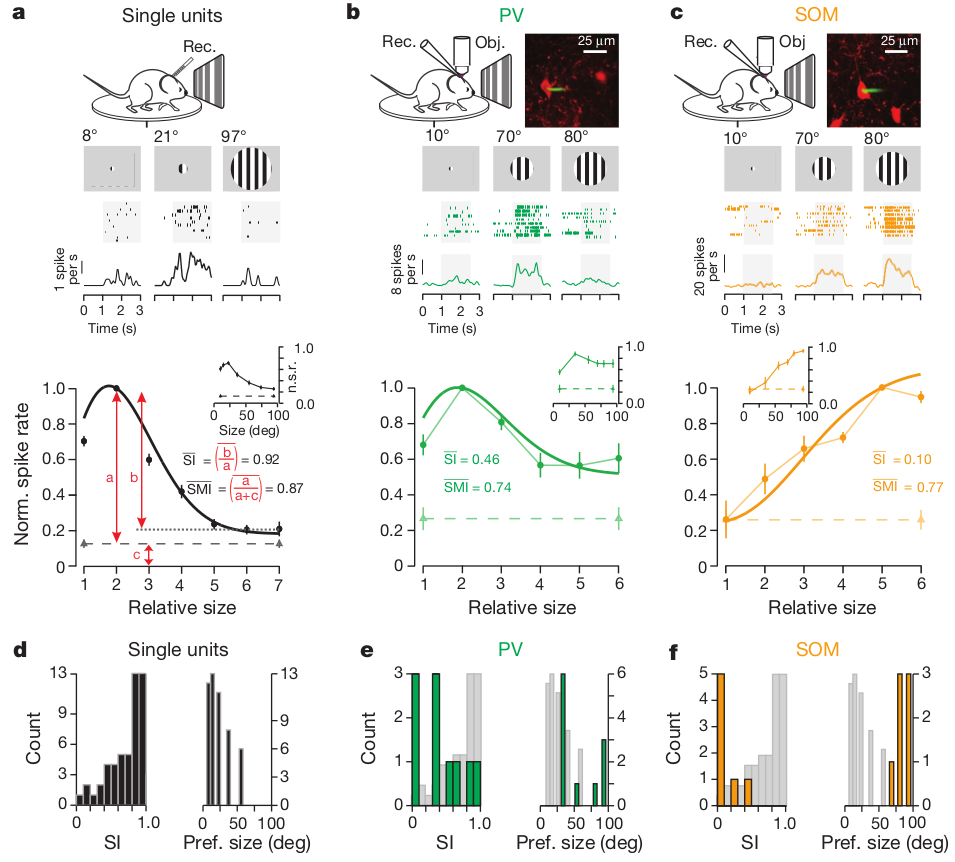

In [37]:
from IPython.display import Image
Image(filename='mouse_tuning_curves.png')

The middle row of this figure shows the tuning curves for three types of neurons in awake, running mice: primary visual cortex neurons (V1, layer 2/3), Parvalbumin-expressing neurons (a class of inhibitory neurons in cortex), and SOM neurons (another cortical inhibitory neuron). The mice are presented with circular patches of drifting gratings at maximum contrast of different sizes (8-97 degrees in diameter, top row). Tuning curves plot firing rate as a function of grating size, with error bars showing +/- SEM. Firing rate for V1 neurons decreased with larger stimuli, revealing the visual surround supression effect investigated in this study. This suppressive surround is though to originate from cortical interneurons: the monotonic increase of SOM neurons' spike rate to grating size suggest that these cells are potential candidates in the generation of this top-down suppressive signal.

## 2. Spike-Triggered Averages

Load the 'c1p8' data file. This data is from Dayan and Abbott's betsite and contains H1 neuron spike data collected by de Ruyter van Steveninck. There are two variables: 'stim' is the stimulus velocity, and 'rho' is the response funciton ($dt=2$ms)

In [38]:
def load_data_two():

	spiking_data=pickle.load(open('c1p8.pkl','rb'))
	stim=spiking_data['stim']
	rho=spiking_data['rho']
	return stim,rho

Plot the spike-triggered average stimulus. You can omit spikes that occur less than a window length after the start of the recording.

In [39]:
#Just to document my misunderstanding, here's what I did initially:
#calculate the average value of the stimulus in the window timesteps
#before each spike, and append this value to the list for each spike.
#produces array.shape=(t,1). 
def spike_trig_avg(stim,spikes,dt,window_width):

	spike_indices=np.where(spikes==1)[0].flatten()
	window = int(window_width / dt)
	spike_triggered_avg=[]
	for i in range(len(spike_indices)):
		stim_sum_i=0
		if i > window: #ignore time points before the first window
			for j in range(window):
				stim_sum_i+=stim[i-j]
		spike_triggered_avg.append(stim_sum_i)

	spike_triggered_avg=np.array(spike_triggered_avg).flatten()/len(spike_indices)

	fig=plt.figure(figsize=(16,8))
	ax=fig.add_subplot(111)
	ax.plot(spike_indices*dt,spike_triggered_avg,
		label='$\\tau_{window}=%s (s)' %window_width)
	ax.set_xlabel('time (seconds)')
	ax.set_ylabel('spike-triggered average')
	plt.show()

In [40]:
#correct method
#for each timestep in the window, find the value of the stimuli at time=t 
#before each spike, and append to the list the average of this value over all spikes
#produces array.shape=(window,1)
def spike_trig_avg2(stim,spikes,dt,window_width):

	window = np.arange(0,int(window_width / dt),1)
	#truncate spikes in first window timesteps
	spike_indices=np.where(spikes[len(window):]==1)[0].flatten()
	spike_triggered_avg=[]
	for t in window:
		stim_sum_i=[]
		for i in spike_indices:
			#undo truncation when indexing from stimulus
			stim_sum_i.append(stim[(i+len(window))-t])
		spike_triggered_avg.append(np.average(stim_sum_i))

	spike_triggered_avg=np.array(spike_triggered_avg).flatten()

	return -1.0*window*dt, spike_triggered_avg

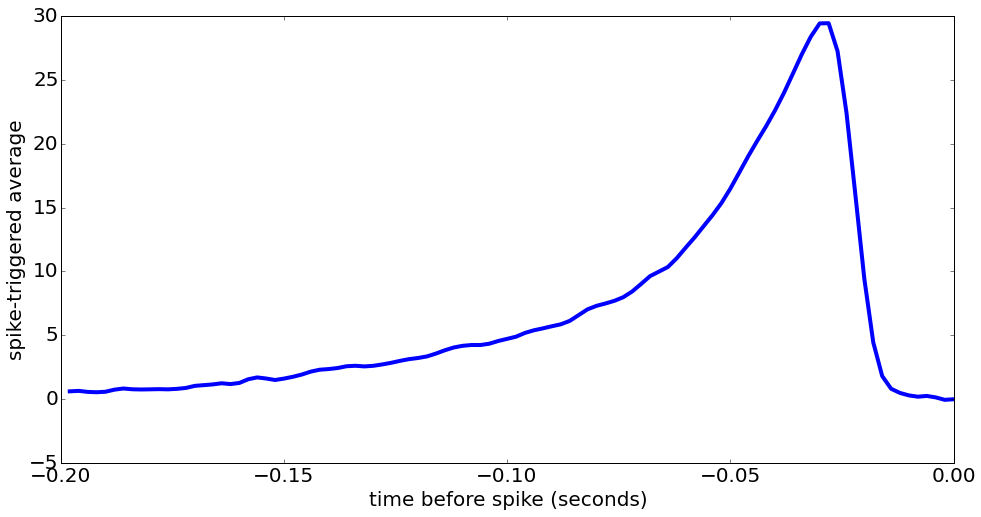

In [41]:
def two_b():

	#load the synthetic data
	stim,rho=load_data_two()
	dt=0.002
	window_width=0.200

	#calculate the spike triggered average
	window, sta = spike_trig_avg2(stim,rho,dt,window_width)
	
	#Plot the spike-triggered average
	fig=plt.figure(figsize=(16,8))
	ax=fig.add_subplot(111)
	ax.plot(window,sta)
	ax.set_xlabel('time before spike (seconds)')
	ax.set_ylabel('spike-triggered average')
	plt.show()
    
two_b()

Generate 100 seconds of approximate white noise by drawing independent Gaussian-distributed samples every ms with $mean=0$ and $SD=1$. Use this as input to the function ```syntheticNeuron()``` and calculate the spike-triggered average of this signal from the output. How and why is it different?

In [42]:
def white_noise(mean=0,std=1,T=100,dt=0.001,rng=np.random.RandomState()):
	return rng.normal(mean,std,T/dt)

def synthetic_neuron(drive):
	"""
	Simulates a mock neuron with a time step of 1ms.
	Arguments:
	drive - input to the neuron (expect zero mean; SD=1)
	Returns:
	rho - response function (0=non-spike and 1=spike at each time step)
	"""	
	  
	dt = 0.001
	T = dt*len(drive)
	time = np.arange(0, T, dt)
	lagSteps = 0.02/dt
	drive = np.concatenate((np.zeros(lagSteps), drive[lagSteps:]))
	system = scipy.signal.lti([1], [0.03**2, 2*0.03, 1])
	_, L, _ = scipy.signal.lsim(system, drive[:,np.newaxis], time)
	rate = np.divide(30, 1 + np.exp(50*(0.05-L)))
	spikeProb = rate*dt
	return np.random.rand(len(spikeProb)) < spikeProb

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:2: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:17: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


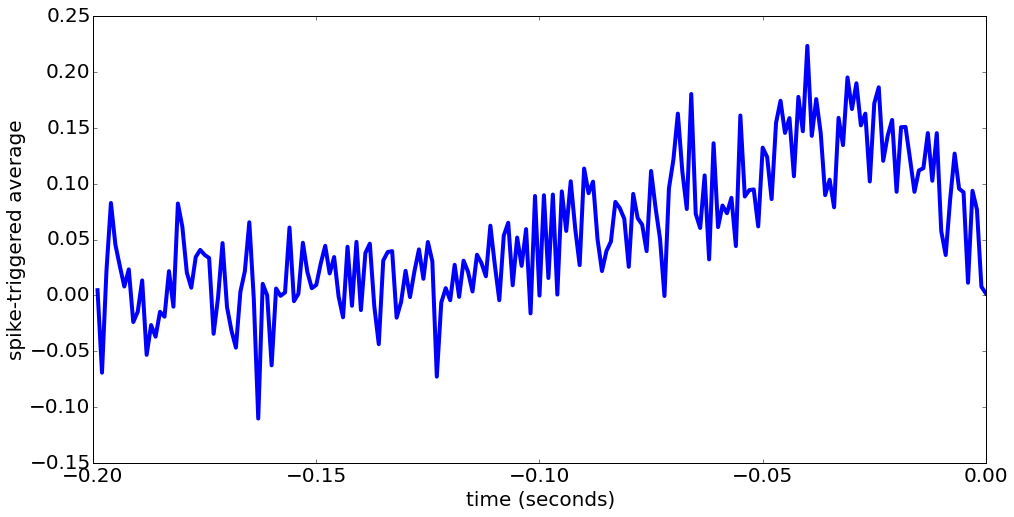

In [43]:
def two_c():

	T=100
	dt=0.001
	mean=0
	std=1
	seed=3

	#generate noisy signal with gaussian sampled numbers
	rng=np.random.RandomState(seed=seed)
	noise=white_noise(mean,std,T,dt,rng)

	#use Bryan's code to get the spikes from an input signal
	spikes=synthetic_neuron(noise)

	#calculate the spike-triggered average
	window_width=0.200
	window, sta = spike_trig_avg2(noise,spikes,dt,window_width)

	#Plot the spike-triggered average
	fig=plt.figure(figsize=(16,8))
	ax=fig.add_subplot(111)
	ax.plot(window,sta)
	ax.set_xlabel('time (seconds)')
	ax.set_ylabel('spike-triggered average')
	plt.show()

two_c()

The spike triggered average of the white noise signal follows a similar pattern to the synthetic signal - stimuli within 2ms of the spike contribute little to spike probability, those within 2-4ms contribute the most, and signals farther back in time have exponentially reduced weight. However, the STA of the noise signal is, unsurprisingly, more noisy than the synthetic signal: while positive stimuli before the spike still drive the neurons towards a spike (and hence increase the STA), there are no longer temporal patterns within the input itself. A positive stimulus value at -2ms does not indicate that there will be positive values at -3ms or -1ms, so these points do not add coherently to the STA, producing a much noisier curve. 

Create colored noise by convolving the white noise you generated above with a Gaussian kernel ($SD=0.020$). Feed the signal into the ```syntheticNeuron()``` function and calculate the spike-triggered average of this signal from the output. How and why is it different?

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:2: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:17: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


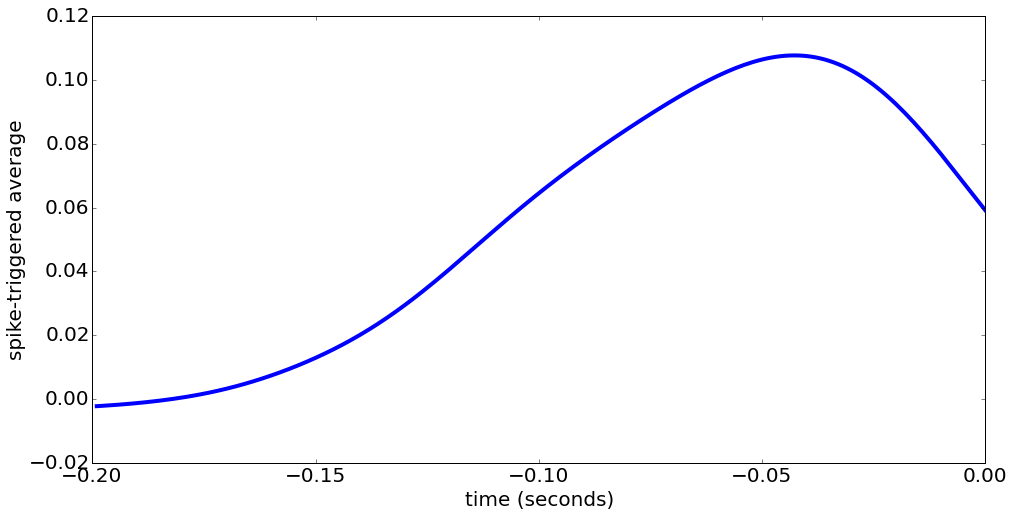

In [44]:
def two_d():

	T=100
	dt=0.001
	mean=0
	std=1
	seed=3

	#generate noisy signal with gaussian sampled numbers
	rng=np.random.RandomState(seed=seed)
	noise=white_noise(mean,std,T,dt,rng)

	#generate colored noise by convolving the noise signal with a gaussian
	t=np.arange(0,T,dt)
	sigma=0.020
	G = np.exp(-(t-np.average(t))**2/(2*sigma**2))     
	G = G / sum(G)
	colored_noise=np.convolve(noise,G,'same')

	#feed colored noise into Bryan's spike generator
	spikes=synthetic_neuron(colored_noise)

	#calculate the spike-triggered average
	window_width=0.200
	window, sta = spike_trig_avg2(colored_noise,spikes,dt,window_width)

	#Plot the spike-triggered average
	fig=plt.figure(figsize=(16,8))
	ax=fig.add_subplot(111)
	ax.plot(window,sta)
	ax.set_xlabel('time (seconds)')
	ax.set_ylabel('spike-triggered average')
	plt.show()
    
two_d()

The STA has the same overall shape as the original white noise signal, but is much smoother. Smoothing the white noise creates temporal correlations within the driving input. The result is that the extent to which each stimulus value contribues to the STA indicates how much the points immediately before and after will contribute. This recreates the smooth shape we saw in ```two_b()```, except that the curve maintains higher values farther back in time. This curvature can be manipulated with the $\sigma$ parameter, but unless the smoothed white noise signal we generate accurately reproduces the spikes incident on a neuron, we wouldn't expect the curvature to precisely match ```two_b()```.  